# Training style classifiers

In [1]:
# ! pip install torchsummary
# ! pip install --upgrade opencv-python
# ! pip install albumentations
# ! pip install s3fs
# ! pip install tqdm
# ! pip install torch
# ! pip install torchvision
# ! conda install --yes pytorch torchvision torchaudio cudatoolkit=11.6 -c pytorch -c conda-forge
# ! pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [2]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import cv2
import albumentations as A
import torchvision.models as models
import os
from tqdm import tqdm
import time
import skimage.io as skio
import warnings
from sklearn.metrics import accuracy_score
warnings.filterwarnings("ignore")

In [3]:
# Read artworks df
artworks = pd.read_csv('artworks.csv')
artworks.head()

,Unnamed: 0,id,title,year,width,height,artistName,image,map,paintingUrl,artistUrl,albums,flags,images,style,Image name,Style-image-name,Present
0,0,57728479edc2cb3880fdea33,Silhouette fantastique,1854,500,366,Victor Hugo,https://uploads0.wikiart.org/images/victor-hug...,0*23**67*,/en/victor-hugo/silhouette-fantastique-1854,/en/victor-hugo,NaN,2,NaN,abstract-art,silhouette-fantastique-1854.jpg,abstract-art-silhouette-fantastique-1854.jpg,abstract-art-silhouette-fantastique-1854.jpg
1,1,57728a62edc2cb388010efa1,First Communion of Anaemic Young Girls in the ...,1883,1324,848,Alphonse Allais,https://uploads0.wikiart.org/images/alphonse-a...,01234*67*,/en/alphonse-allais/first-communion-of-anaemic...,/en/alphonse-allais,NaN,2,NaN,abstract-art,first-communion-of-anaemic-young-girls-in-the-...,abstract-art-first-communion-of-anaemic-young-...,abstract-art-first-communion-of-anaemic-young-...
2,2,57728a61edc2cb388010ef5f,Apoplectic Cardinals Harvesting Tomatoes on th...,1884,1400,980,Alphonse Allais,https://uploads2.wikiart.org/images/alphonse-a...,01234*67*,/en/alphonse-allais/apoplectic-cardinals-harve...,/en/alphonse-allais,NaN,2,NaN,abstract-art,apoplectic-cardinals-harvesting-tomatoes-on-th...,abstract-art-apoplectic-cardinals-harvesting-t...,abstract-art-apoplectic-cardinals-harvesting-t...
3,3,57728a61edc2cb388010ef71,Band of Greyfriars in the Fog (Band Of Dusty D...,1884,1400,980,Alphonse Allais,https://uploads2.wikiart.org/images/alphonse-a...,01234*67*,/en/alphonse-allais/band-of-greyfriars-in-the-...,/en/alphonse-allais,NaN,2,NaN,abstract-art,band-of-greyfriars-in-the-fog-band-of-dusty-dr...,abstract-art-band-of-greyfriars-in-the-fog-ban...,abstract-art-band-of-greyfriars-in-the-fog-ban...
4,4,57728a61edc2cb388010ef81,Negroes Fighting in a Tunnel by Night,1884,800,560,Alphonse Allais,https://uploads5.wikiart.org/images/alphonse-a...,0123**67*,/en/alphonse-allais/negroes-fighting-in-a-tunn...,/en/alphonse-allais,NaN,2,NaN,abstract-art,negroes-fighting-in-a-tunnel-by-night.jpg,abstract-art-negroes-fighting-in-a-tunnel-by-n...,abstract-art-negroes-fighting-in-a-tunnel-by-n...


In [4]:
# Create col w/ S3 filename
artworks['s3_path'] = artworks.apply(lambda row: row['style'] \
                                     + "/" + row['image'].split('/')[-1].split('.')[0] + ".jpg", 
                                     axis=1)
artworks['s3_path'][0]

'abstract-art/silhouette-fantastique-1854.jpg'

In [5]:
artworks.head(2)

,Unnamed: 0,id,title,year,width,height,artistName,image,map,paintingUrl,artistUrl,albums,flags,images,style,Image name,Style-image-name,Present,s3_path
0,0,57728479edc2cb3880fdea33,Silhouette fantastique,1854,500,366,Victor Hugo,https://uploads0.wikiart.org/images/victor-hug...,0*23**67*,/en/victor-hugo/silhouette-fantastique-1854,/en/victor-hugo,NaN,2,NaN,abstract-art,silhouette-fantastique-1854.jpg,abstract-art-silhouette-fantastique-1854.jpg,abstract-art-silhouette-fantastique-1854.jpg,abstract-art/silhouette-fantastique-1854.jpg
1,1,57728a62edc2cb388010efa1,First Communion of Anaemic Young Girls in the ...,1883,1324,848,Alphonse Allais,https://uploads0.wikiart.org/images/alphonse-a...,01234*67*,/en/alphonse-allais/first-communion-of-anaemic...,/en/alphonse-allais,NaN,2,NaN,abstract-art,first-communion-of-anaemic-young-girls-in-the-...,abstract-art-first-communion-of-anaemic-young-...,abstract-art-first-communion-of-anaemic-young-...,abstract-art/first-communion-of-anaemic-young-...


In [6]:
artworks['style'].value_counts()

surrealism                    3581
symbolism                     3580
impressionism                 3580
romanticism                   3572
art-nouveau-modern            3567
realism                       3566
abstract-expressionism        3564
baroque                       3560
naive-art-primitivism         3559
rococo                        3557
post-impressionism            3532
neoclassicism                 3528
expressionism                 3497
cubism                        3409
northern-renaissance          3256
pop-art                       2656
mannerism-late-renaissance    2512
minimalism                    2231
abstract-art                  2037
early-renaissance             1864
ukiyo-e                       1854
high-renaissance              1747
magic-realism                 1745
art-informel                  1629
color-field-painting          1591
Name: style, dtype: int64

In [7]:

file = 'abstract-art/0-42-69-1969.jpg'
img = cv2.imread(file)

In [8]:
img.shape

(433, 640, 3)

### Data Augmentations

In [9]:
# Define transformations
transforms = A.Compose([
    A.Flip(p=0.5),
    A.Rotate(limit=10, 
             border_mode=cv2.BORDER_CONSTANT, 
             value=0.0, p=0.75),
    A.RandomResizedCrop(width=224, height=224, scale=(0.5, 1), p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225), 
                max_pixel_value=255.0, 
                p=1.0)
])

Normalizes, resulting image looks strange:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


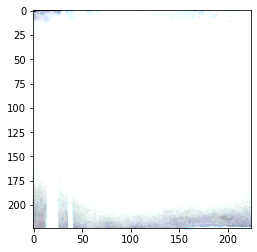

In [10]:
transformed = transforms(image=img.astype(np.uint8))
img = transformed['image']
plt.imshow(img)

In [11]:
img.shape

(224, 224, 3)

## Dataset Class

In [12]:
class ArtDataset(Dataset):
    def __init__(self, df, label_dict, transforms, fs= None):
        self.df = df
        self.transforms = transforms
        self.label_dict = label_dict
        self.fs = fs
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Get filename and label
        filename = row['s3_path']
        #label = torch.zeros(25, dtype = torch.long)
        label = torch.tensor(label_dict[row['style']], dtype = torch.long)
        # Read image, correct color channels
        img = self.load_img(filename)
#        print(img)
        # adding this portion if the image has 4 channels or more -- Chandrish
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis = 2)
            img = np.repeat(img, 3, axis = 2)
        elif img.shape[2] > 3:
            img = img[:, :, :3]
        # Augmentations + normalization
        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']
        
        img = img.transpose(2, 0, 1)
        # Convert to tensor
        img = torch.tensor(img).float()
        #img = torch.permute(2, 0, 1)
        return img, label
    
    def load_img(self, s3_path):
        try:
            img_arr = skio.imread(s3_path)
            img_arr.shape
        except:
            img_arr = skio.imread('symbolism/baroness-fernand-van-der-bruggen-1900.jpg')
        return img_arr

Try removing bad files from the dataframe
8312, 25221, 26899, 29243, 32929, 47916

## Transfer learning functions

In [13]:
def set_classification_layer(model, model_type='vgg', num_classes=25):
    if model_type == 'vgg':
        model.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=num_classes, bias=True)
        )
    elif model_type == 'resnet':
        model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
    elif model_type == 'vit':
        model.heads = nn.Linear(in_features=768, out_features=num_classes, bias=True)
    elif model_type == 'convnext':
        model.classifier = nn.Sequential(
            nn.LayerNorm2d((768,), eps=1e-06, elementwise_affine=True),
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features=768, out_features=num_classes, bias=True)
        )
    else:
        print(f'Unknown model_type {model_type}. Acceptable types are: "vgg", "resnet", "vit", or "convnext"')   

In [14]:
def freeze_model(model, **classargs):
    '''
    Given an existing model, freeze pre-trained weights and
    re-instantiate the classifier.
    '''
    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False
    # Re-instantiate the classifier head
    model = set_classification_layer(model, **classargs)

In [15]:
# Load VGG-19
vgg = models.vgg19()
for name, param in vgg.named_parameters():
    print(f"{name} gradient is set to", param.requires_grad)

features.0.weight gradient is set to True
features.0.bias gradient is set to True
features.2.weight gradient is set to True
features.2.bias gradient is set to True
features.5.weight gradient is set to True
features.5.bias gradient is set to True
features.7.weight gradient is set to True
features.7.bias gradient is set to True
features.10.weight gradient is set to True
features.10.bias gradient is set to True
features.12.weight gradient is set to True
features.12.bias gradient is set to True
features.14.weight gradient is set to True
features.14.bias gradient is set to True
features.16.weight gradient is set to True
features.16.bias gradient is set to True
features.19.weight gradient is set to True
features.19.bias gradient is set to True
features.21.weight gradient is set to True
features.21.bias gradient is set to True
features.23.weight gradient is set to True
features.23.bias gradient is set to True
features.25.weight gradient is set to True
features.25.bias gradient is set to True


In [16]:
# Freeze model
freeze_model(vgg, num_classes=25, model_type='vgg')
#vgg.classifier

In [17]:
# Check frozen layers
for name, param in vgg.named_parameters():
    print(f"{name} gradient is set to", param.requires_grad)

features.0.weight gradient is set to False
features.0.bias gradient is set to False
features.2.weight gradient is set to False
features.2.bias gradient is set to False
features.5.weight gradient is set to False
features.5.bias gradient is set to False
features.7.weight gradient is set to False
features.7.bias gradient is set to False
features.10.weight gradient is set to False
features.10.bias gradient is set to False
features.12.weight gradient is set to False
features.12.bias gradient is set to False
features.14.weight gradient is set to False
features.14.bias gradient is set to False
features.16.weight gradient is set to False
features.16.bias gradient is set to False
features.19.weight gradient is set to False
features.19.bias gradient is set to False
features.21.weight gradient is set to False
features.21.bias gradient is set to False
features.23.weight gradient is set to False
features.23.bias gradient is set to False
features.25.weight gradient is set to False
features.25.bias g

## Training functions

In [18]:
# Dictionary for easily passing training arguments
training_params = {'epochs': 20,
                  'batch_size': 16,
                  'loss_fct': nn.CrossEntropyLoss()}


def eval_model(model, dl, training_params):
    # Get GPU if available
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    # Evaluate
    model.eval()
    # model = model.to(device)
    total_loss = 0
    total_obs = 0
    total_correct = 0
    loss_fct = training_params['loss_fct']
    for X, y in tqdm(dl):
        n_obs = len(y)
        # Forward pass and calculate loss
        yhat = model(X.to(device))#.softmax(dim=1)
        loss = loss_fct(yhat.to(device), y.to(device))
        total_loss += n_obs * loss.item()
        total_obs += n_obs
        # Calculate batch accuracy
        ypred = np.argmax(yhat.cpu().detach().numpy(), axis=1)
        y_arr = y.detach().numpy()
        total_correct += n_obs * accuracy_score(y_arr, ypred)
    # Return loss, accuracy
    avg_loss = total_loss / total_obs
    accuracy = total_correct / total_obs
    return avg_loss, accuracy
    
    
def train_model(model, optimizer, scheduler, train_ds, valid_ds, training_params):
    # Get loss function
    loss_fct = training_params['loss_fct']
    # Create dataloaders based on batch size
    batch_size = training_params['batch_size']
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
    # Get GPU if available
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    # Train
    for _ in range(training_params['epochs']):
        # Put model in train mode
        model.train()
        # Train on training dataloader
        for X, y in tqdm(train_dl):
            # Clear gradients
            optimizer.zero_grad()
            # Forward pass and loss calculation
            yhat = model(X.to(device))#.softmax(dim=1)
            loss = loss_fct(yhat.to(device), y.to(device))
            # Backward pass and step
            loss.backward()
            optimizer.step()
        scheduler.step()  # update scheduler each epoch
        # Calculate loss, accuracy on train and validation
        train_loss, train_acc = eval_model(model, train_dl, training_params)
        valid_loss, valid_acc = eval_model(model, valid_dl, training_params)
        train_str = f"train loss: {train_loss:.4f} | train acc: {train_acc:.4f}"
        valid_str = f" | valid loss: {valid_loss:.4f} | valid acc: {valid_acc:.4f}"
        print(f'[{_}] ' + train_str + valid_str)

### Train Val Test Split

In [20]:
df = artworks.sample(frac = 1, random_state = 62).reset_index(drop = True)
split1 = int(0.7 * df.shape[0])
split2 = int(0.85 * df.shape[0])
train_df, valid_df, test_df = df.iloc[:split1].copy(), df.iloc[split1: split2].reset_index(drop = True), \
                                    df.iloc[split2:].reset_index(drop = True)

### Instantiate Datasets

In [21]:
label_dict = {style: i for i, style in enumerate(sorted(artworks['style'].unique()))}

In [22]:
# creating Datasets
train_ds = ArtDataset(train_df, label_dict, transforms)
valid_ds = ArtDataset(train_df, label_dict, transforms)
test_ds = ArtDataset(train_df, label_dict, transforms)

In [24]:
# testing datasets
train_ds[0][0].shape, train_ds[0][1].shape

(torch.Size([3, 224, 224]), torch.Size([]))

In [25]:
# testing dataloaders
x, y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

----

### Training - VGG 19

In [26]:
# Trying VGG 19
from torchvision.models import vgg19
model = vgg19(pretrained = True)

In [27]:
# freezing the parameters
freeze_model(model, num_classes=25, model_type='vgg')

In [28]:
from torch.optim.lr_scheduler import StepLR
optimizer = optim.Adam(model.parameters(), )
scheduler = StepLR(optimizer, step_size=4, gamma=0.5)
training_params = {'epochs': 10,
                  'batch_size': 128,
                  'loss_fct': nn.CrossEntropyLoss()}

In [29]:
train_model(model, optimizer, scheduler, train_ds, valid_ds, training_params)

  0%|                                                                                                         | 0/398 [00:00<?, ?it/s]/home/vambati/anaconda3/envs/deep-learning/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  1%|▍                                                                                                | 2/398 [00:17<57:40,  8.74s/it]/home/vambati/anaconda3/envs/deep-learning/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 33723 had too many entries: 2, expected 1
  warnings.warn(
/home/vambati/anaconda3/envs/deep-learning/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
  3%|██▉                                                                                             | 12/398 [01:25<44:27,  6.91s/it]/ho

TypeError: eval_model() missing 1 required positional argument: 'training_params'

### Training - ResNet 34

In [42]:
# Trying Resnet 34
from torchvision.models import resnet34
model = resnet34(pretrained = True)

In [44]:
freeze_model(model, num_classes=25, model_type='resnet')

In [45]:
from torch.optim.lr_scheduler import StepLR
optimizer = optim.Adam(model.parameters(), lr = 4e-4)
scheduler = StepLR(optimizer, step_size=4, gamma=0.5)
training_params = {'epochs': 10,
                  'batch_size': 256,
                  'loss_fct': nn.CrossEntropyLoss()}

In [46]:
train_model(model, optimizer, scheduler, train_ds, valid_ds, training_params)

 10%|█████████▏                                                                                      | 19/199 [05:54<55:55, 18.64s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/vambati/anaconda3/envs/deep-learning/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2153458/4141321183.py", line 1, in <module>
    train_model(model, optimizer, scheduler, train_ds, valid_ds, training_params)
  File "/tmp/ipykernel_2153458/3394249560.py", line 49, in train_model
    for X, y in tqdm(train_dl):
  File "/home/vambati/anaconda3/envs/deep-learning/lib/python3.9/site-packages/tqdm/std.py", line 1195, in __iter__
    for obj in iterable:
  File "/home/vambati/anaconda3/envs/deep-learning/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 521, in __next__
    data = self._next_data()
  File "/home/vambati/anaconda3/envs/deep-learning/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 561, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/

TypeError: object of type 'NoneType' has no len()

### Training - ViT

In [29]:
from torchvision.models import vit_b_16
model = vit_b_16(pretrained = True)
freeze_model(model, num_classes=25, model_type='vit')

In [30]:
from torch.optim.lr_scheduler import StepLR
optimizer = optim.Adam(model.parameters(), lr = 4e-4)
scheduler = StepLR(optimizer, step_size=4, gamma=0.5)
training_params = {'epochs': 10,
                  'batch_size': 256,
                  'loss_fct': nn.CrossEntropyLoss()}

In [31]:
train_model(model, optimizer, scheduler, train_ds, valid_ds, training_params)

  9%|████████▌                                                                                     | 18/199 [07:04<1:11:12, 23.60s/it]


KeyboardInterrupt: 

----

----

### Rough

In [43]:
%%time
training_params = {'epochs': 10,
                  'batch_size': 128,
                  'loss_fct': nn.CrossEntropyLoss()}

train_loss, train_acc = eval_model(model, train_dl, training_params)
valid_loss, valid_acc = eval_model(model, valid_dl, training_params)
train_str = f"train loss: {train_loss:.4f} | train acc: {train_acc:.4f}"
valid_str = f" | valid loss: {valid_loss:.4f} | valid acc: {valid_acc:.4f}"
print(f'[{_}] ' + train_str + valid_str)

  2%|█▉                                                                                               | 8/398 [00:55<45:05,  6.94s/it]


KeyboardInterrupt: 

In [47]:
torch.save(model.state_dict(), 'models/vgg19_epoch1.pth')

In [ ]:
for i in tqdm(range(47917,len(train_ds))):
    train_ds[i]

In [ ]:
# 8312, 25221, 26899, 29243, 32929, 47916

In [ ]:
train_ds[8312]

In [ ]:
train_ds[8312]

In [ ]:
pth = train_df.iloc[i]['s3_path']

In [ ]:
pth

In [ ]:
img = skio.imread(pth)

In [ ]:
img.shape

In [ ]:
if len(img.shape) == 2:
    img = np.expand_dims(img, axis = 2)
    img = np.repeat(img, 3, axis = 2)
elif img.shape[2] > 3:
    img = img[:, :, :3]

In [ ]:
img.shape

In [ ]:
train_model(model, optimizer, scheduler, train_ds, valid_ds, training_params)

In [ ]:
# Check frozen layers
for name, param in model.named_parameters():
    print(f"{name} gradient is set to", param.requires_grad)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model
yhat = model(x.to(device))

In [ ]:
yhat.shape

In [ ]:
y.shape

In [ ]:
loss = training_params['loss_fct'](yhat.to(device), y.to(device))

In [ ]:
import torch.nn.functional as F
F.cross_entropy(yhat, y)

In [ ]:
torch.cuda.is_available()

training_params


* torchvision model --> VGG, ResNet, ViT
* Learning rate scheduler: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html
* Torchvision models: https://pytorch.org/vision/stable/models.html